In [1]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [2]:
# Avoid OOM error by setting GPU Memory Consumption to Growth
gpus = tf.config.list_physical_devices('GPU')
if (len(gpus) > 0) :
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print('You do not have a GPU available')

You do not have a GPU available


(194, 259, 3)


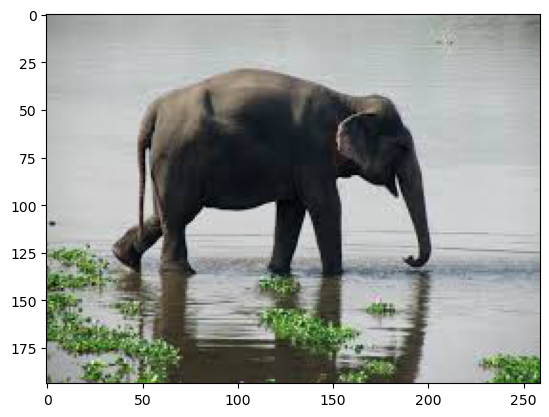

In [3]:
# Viewing an Image
img = cv2.imread(os.path.join("data", "train", "Asian", 'as_tr1.jpg'))
print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
train_dir="./data/train/"
test_dir = "./data/test"

In [5]:
import pathlib
data_dir = pathlib.Path(train_dir) # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
class_names = class_names.tolist() # convert numpy array to list
n_classes = len(class_names)
print(class_names, n_classes)

['African', 'Asian'] 2


In [6]:
# Define image size
IMG_SIZE = (224, 224)

# Create a training dataset
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode="binary",
    batch_size=32  # This is generally a good batch size
)

# Create a test dataset
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=IMG_SIZE,
    label_mode="binary",
)

Found 840 files belonging to 2 classes.
Found 188 files belonging to 2 classes.


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
normalization_layer = layers.Rescaling(1./255)

In [9]:
model = tf.keras.models.Sequential([
   tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(32,(3,3), activation='relu'), # first layer specifies input shape (height, width, colour channels)
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [10]:
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [11]:
history = model.fit(train_data,
                        epochs=20,
                        steps_per_epoch=len(train_data),
                        validation_data=train_data,
                        validation_steps=len(train_data))

Epoch 1/20
27/27 [==============================] - 213s 8s/step - loss: 0.9261 - accuracy: 0.5286 - val_loss: 0.7292 - val_accuracy: 0.4083
Epoch 2/20
27/27 [==============================] - 202s 8s/step - loss: 0.7753 - accuracy: 0.5726 - val_loss: 1.9611 - val_accuracy: 0.4988
Epoch 3/20
27/27 [==============================] - 201s 7s/step - loss: 0.7859 - accuracy: 0.5905 - val_loss: 1.1403 - val_accuracy: 0.5000
Epoch 4/20
27/27 [==============================] - 201s 8s/step - loss: 0.7888 - accuracy: 0.6131 - val_loss: 1.8784 - val_accuracy: 0.5000
Epoch 5/20
27/27 [==============================] - 202s 8s/step - loss: 0.6940 - accuracy: 0.6667 - val_loss: 0.7704 - val_accuracy: 0.5071
Epoch 6/20
27/27 [==============================] - 203s 8s/step - loss: 0.6041 - accuracy: 0.6917 - val_loss: 1.2241 - val_accuracy: 0.4988
Epoch 7/20
27/27 [==============================] - 207s 8s/step - loss: 0.5559 - accuracy: 0.7464 - val_loss: 1.2270 - val_accuracy: 0.4988
Epoch 8/20
27

In [12]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

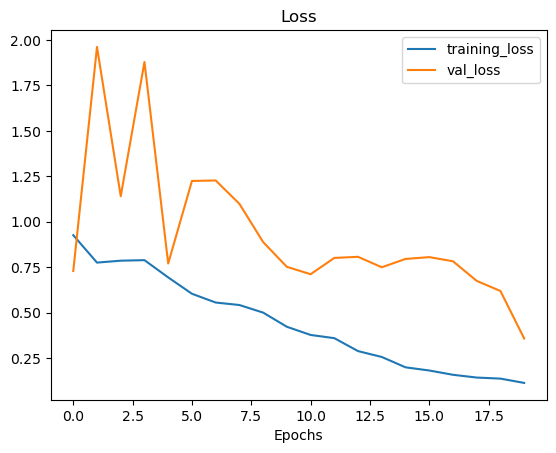

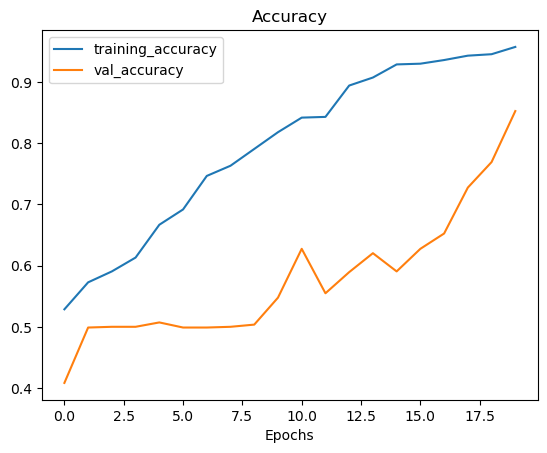

In [13]:
plot_loss_curves(history)

In [14]:
evaluation = model.evaluate(test_data)
evaluation

6/6 [==============================] - 6s 860ms/step - loss: 0.5379 - accuracy: 0.7979


[0.5379389524459839, 0.7978723645210266]

In [15]:
def plot_random_images(model, dataset, classes):
  # Pick a random batch
  images, true_labels = next(iter(dataset.shuffle(1000)))

  # Setup 20 random integers
  indices = tf.random.uniform(shape=[20], minval=0, maxval=tf.shape(images)[0], dtype=tf.int32)

  fig, axes = plt.subplots(5, 4, figsize=(10, 10))  # We'll have 5 rows of 4 images each

  for i, ax in enumerate(axes.flat):
    # Create predictions and targets
    target_image = images[indices[i]]
    pred_probs = model.predict(target_image[tf.newaxis, ...], verbose=0)

    # Check the number of unique classes
    if len(classes) > 2:  # multiclass classification
      pred_label = classes[tf.argmax(pred_probs[0])]
      true_label = classes[tf.argmax(true_labels[indices[i]])]
    else:  # binary classification
      pred_label = classes[int(tf.round(tf.reduce_max(pred_probs[0])))]
      true_label = classes[int(tf.squeeze(true_labels[indices[i]]))]

    # Plot the target image
    ax.imshow(target_image.numpy().astype("uint8"))

    # Change the color of the titles depending on if the prediction is right or wrong
    color = "green" if pred_label == true_label else "red"

    # Add xlabel information (prediction/true label)
    ax.set_xlabel("Pred: {} {:2.0f}% (True: {})".format(pred_label,
                                                       100*tf.reduce_max(pred_probs),
                                                       true_label),
                 color=color)

  plt.tight_layout()
  plt.show()

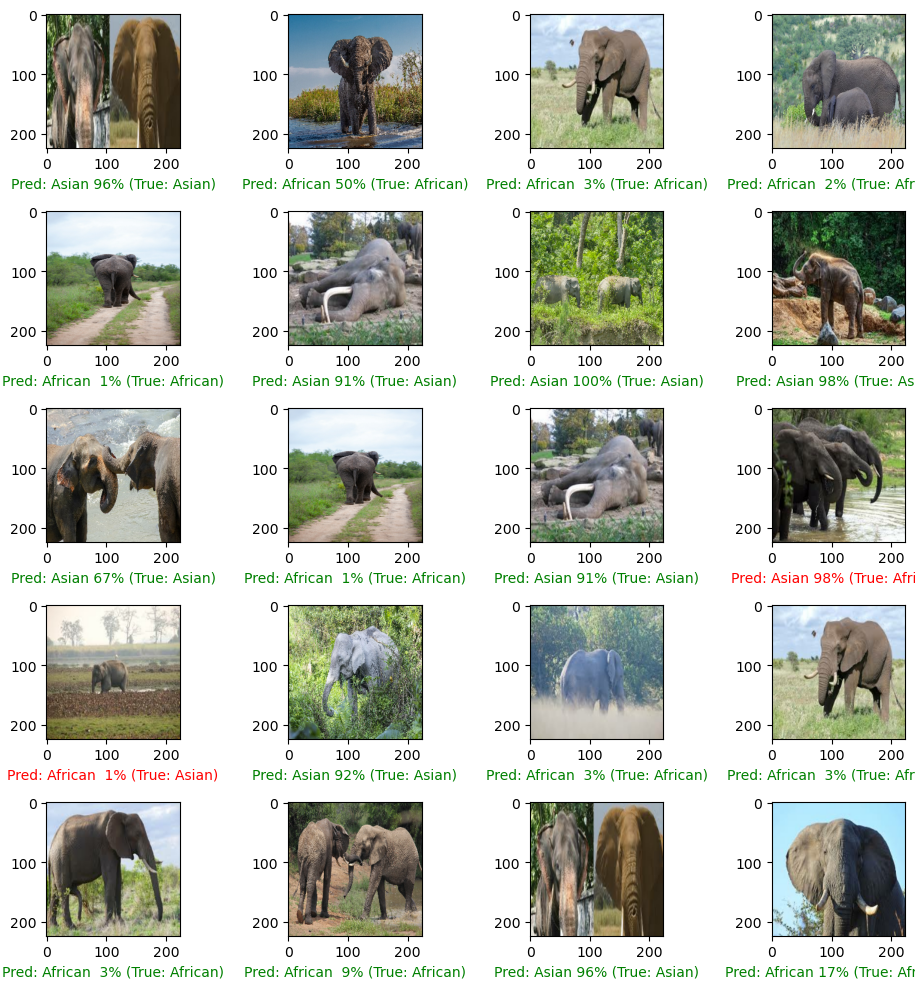

In [16]:
plot_random_images(model=model,
                   dataset=test_data,
                   classes=class_names)

In [17]:
model.save('elephant_prediction.h5')

C:\Users\dhruv\anaconda3\envs\tf\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
